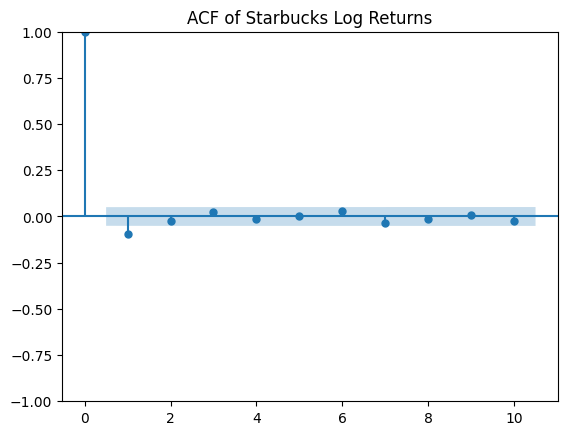

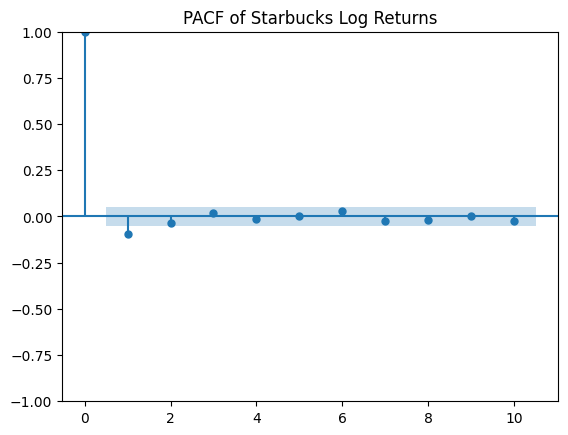

Ljung-Box Test Result (lags = 10):
      lb_stat  lb_pvalue
1   13.661815   0.000219
2   14.496589   0.000711
3   15.259077   0.001608
4   15.657315   0.003515
5   15.678812   0.007823
6   16.837627   0.009899
7   18.450421   0.010095
8   18.669801   0.016729
9   18.745411   0.027447
10  19.822642   0.030976
存在显著序列相关性（拒绝白噪声假设）


In [13]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# -------------------------------
# Step 1: 读取数据并预处理
# -------------------------------
# 包含三列：日期、SBUX 简单收益、S&P500 简单收益
df = pd.read_csv("d-sbuxsp0106.txt", sep='\s+', header=None, names=["Date", "SBUX_simple", "SP500_simple"])

# 将日期列转为 datetime 格式，并按时间排序
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# -------------------------------
# Step 2: 转换为百分比对数收益率（log return）
# -------------------------------
df["SBUX_log"] = 100 * np.log(1 + df["SBUX_simple"])
df["SP500_log"] = 100 * np.log(1 + df["SP500_simple"])

# -------------------------------
# Step 3: 画出 SBUX log return 的 ACF 图
# -------------------------------
sbux_log = df["SBUX_log"].dropna()

# ACF/PACF 图
plot_acf(sbux_log, lags=10)
plt.title("ACF of Starbucks Log Returns")
plt.show()

plot_pacf(sbux_log, lags=10)
plt.title("PACF of Starbucks Log Returns")
plt.show()

# -------------------------------
# Step 4: 使用 Ljung-Box 检验判断是否存在序列相关性
# -------------------------------
ljung = acorr_ljungbox(sbux_log, lags=10, return_df=True)
print("Ljung-Box Test Result (lags = 10):")
print(ljung)

if (ljung["lb_pvalue"] < 0.05).any():
    print("存在显著序列相关性（拒绝白噪声假设）")
else:
    print("未发现显著序列相关性")

In [14]:
# 导入检验 ARCH 效应的工具
from statsmodels.stats.diagnostic import het_arch

# -------------------------------
# Step 2: 进行 ARCH-LM 检验（10 阶滞后）
# -------------------------------
# het_arch 返回值: (LM统计量, p值, F统计量, F的p值)
arch_test_result = het_arch(sbux_log, nlags=10)

# 展示结果
print("ARCH-LM Test Result (lags = 10):")
print(f"LM Statistic: {arch_test_result[0]:.4f}")
print(f"LM p-value  : {arch_test_result[1]:.4f}")
print(f"F Statistic : {arch_test_result[2]:.4f}")
print(f"F p-value   : {arch_test_result[3]:.4f}")

# -------------------------------
# Step 3: 结论判断
# -------------------------------
if arch_test_result[1] < 0.05:
    print("存在显著 ARCH 效应（拒绝无异方差假设）")
else:
    print("未发现显著 ARCH 效应（不能拒绝无异方差假设）")

ARCH-LM Test Result (lags = 10):
LM Statistic: 39.3433
LM p-value  : 0.0000
F Statistic : 4.0108
F p-value   : 0.0000
存在显著 ARCH 效应（拒绝无异方差假设）


                     Constant Mean - GARCH Model Results                      
Dep. Variable:               SBUX_log   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3150.52
Distribution:                  Normal   AIC:                           6309.04
Method:            Maximum Likelihood   BIC:                           6330.31
                                        No. Observations:                 1507
Date:                Fri, Apr 11 2025   Df Residuals:                     1506
Time:                        15:19:00   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1181  4.946e-02      2.389  1.692e-02 [2.120e-0

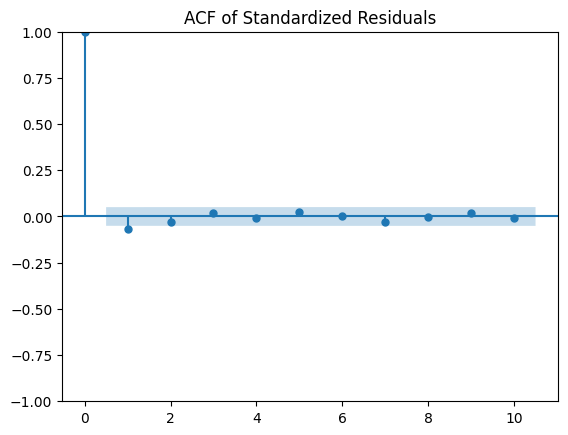


残差 ARCH-LM 检验结果（标准化残差平方）:
LM Statistic: 5.2399, p-value: 0.8746
残差未发现 ARCH 效应 → 模型拟合较好

拟合的 GARCH(1,1) 模型为：
r_t = 0.1181 + ε_t
ε_t = z_t * sqrt(h_t), z_t ~ N(0,1)
h_t = 0.0140 + 0.0143 * ε_(t-1)^2 + 0.9814 * h_(t-1)


In [ ]:
from arch import arch_model
import seaborn as sns

# -------------------------------
# Step 2: 拟合 GARCH(1,1) 模型，正态分布假设
# -------------------------------
model = arch_model(sbux_log, vol='GARCH', p=1, q=1, dist='normal')
garch_fit = model.fit(disp='off')

# 输出拟合结果
print(garch_fit.summary())
# -------------------------------
# Step 3: 模型残差诊断
# -------------------------------
resid = garch_fit.resid
std_resid = garch_fit.std_resid

# ACF 图：标准化残差
plot_acf(std_resid, lags=10)
plt.title("ACF of Standardized Residuals")
plt.show()

# ARCH-LM 检验残差平方
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, _, _ = het_arch(std_resid.dropna(), nlags=10)

print(f"\n残差 ARCH-LM 检验结果（标准化残差平方）:")
print(f"LM Statistic: {lm_stat:.4f}, p-value: {lm_pvalue:.4f}")
if lm_pvalue < 0.05:
    print("残差仍存在 ARCH 效应 → 模型可能不充分")
else:
    print("残差未发现 ARCH 效应 → 模型拟合较好")

# -------------------------------
# Step 4: 写出模型形式（含参数）
# -------------------------------
params = garch_fit.params
mu = params['mu']
omega = params['omega']
alpha = params['alpha[1]']
beta = params['beta[1]']

print("\n拟合的 GARCH(1,1) 模型为：")
print(f"r_t = {mu:.4f} + ε_t")
print(f"ε_t = z_t * sqrt(h_t), z_t ~ N(0,1)")
print(f"h_t = {omega:.4f} + {alpha:.4f} * ε_(t-1)^2 + {beta:.4f} * h_(t-1)")

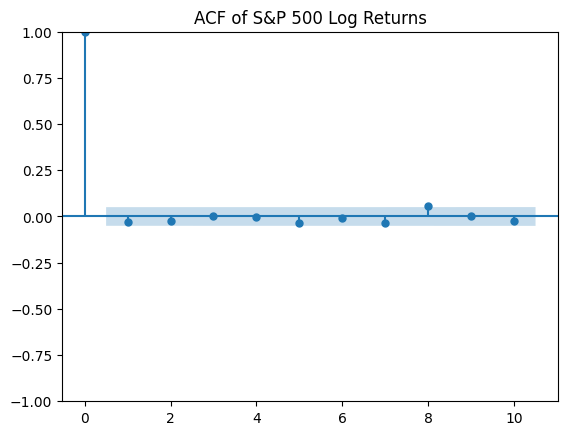

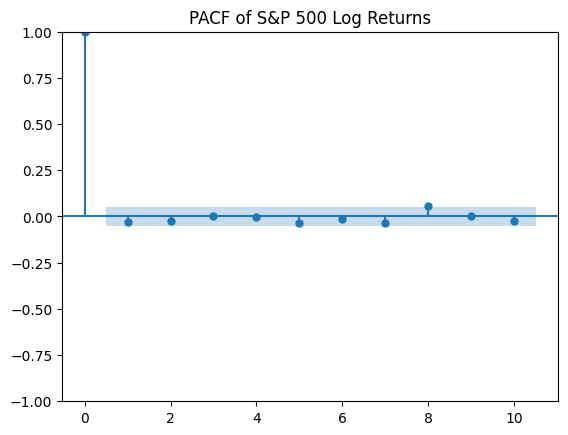

Ljung-Box Test Result (lags = 10) for SP500 log return:
      lb_stat  lb_pvalue
1    1.508860   0.219313
2    2.425776   0.297337
3    2.449644   0.484460
4    2.463175   0.651242
5    4.368552   0.497661
6    4.506415   0.608484
7    6.277432   0.507754
8   11.307232   0.184891
9   11.315007   0.254733
10  12.252972   0.268483
SP500 log return 未发现显著序列相关性


In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# -------------------------------
# Step 1: 提取 SP500 的 log return 序列
# -------------------------------
sp_log = df["SP500_log"].dropna()

# -------------------------------
# Step 2: ACF 图
# -------------------------------
# ACF/PACF 图
plot_acf(sp_log, lags=10)
plt.title("ACF of S&P 500 Log Returns")
plt.show()

plot_pacf(sp_log, lags=10)
plt.title("PACF of S&P 500 Log Returns")
plt.show()
# -------------------------------
# Step 3: Ljung-Box 检验（判断是否存在整体序列相关性）
# -------------------------------
sp_ljung = acorr_ljungbox(sp_log, lags=10, return_df=True)
print("Ljung-Box Test Result (lags = 10) for SP500 log return:")
print(sp_ljung)

if (sp_ljung["lb_pvalue"] < 0.05).any():
    print("SP500 log return 存在显著序列相关性")
else:
    print("SP500 log return 未发现显著序列相关性")

In [17]:
from statsmodels.stats.diagnostic import het_arch

# -------------------------------
# Step 4: ARCH-LM 检验（10阶）
# -------------------------------
arch_test_sp = het_arch(sp_log, nlags=10)

print("\nARCH-LM Test Result (SP500 log return, lags = 10):")
print(f"LM Statistic: {arch_test_sp[0]:.4f}")
print(f"LM p-value  : {arch_test_sp[1]:.4f}")

if arch_test_sp[1] < 0.05:
    print("存在显著 ARCH 效应（SP500）")
else:
    print("未发现显著 ARCH 效应（SP500）")


ARCH-LM Test Result (SP500 log return, lags = 10):
LM Statistic: 330.2333
LM p-value  : 0.0000
存在显著 ARCH 效应（SP500）


In [ ]:
from arch import arch_model
# -------------------------------
# Step 2: 拟合 IGARCH(1,1) 模型（dist='normal'）
# -------------------------------
# 设置 garch 模型，设置 power=2，固定 alpha + beta = 1
model_igarch = arch_model(sp_log, vol='GARCH', p=1, q=1, dist='normal')
model_igarch.fix_param = {'omega': 0.0}  # IGARCH 假设下 omega 必须为 0
igarch_fit = model_igarch.fit(disp='off')

# -------------------------------
# Step 3: 输出模型估计结果
# -------------------------------
print(igarch_fit.summary())

# 提取参数（便于后面写出模型表达式）
params = igarch_fit.params
mu = params['mu']
alpha = params['alpha[1]']
beta = params['beta[1]']

print("\n拟合的 IGARCH(1,1) 模型为：")
print(f"r_t = {mu:.4f} + ε_t")
print(f"ε_t = z_t * sqrt(h_t), z_t ~ N(0,1)")
print(f"h_t = {alpha:.4f} * ε_(t-1)^2 + {beta:.4f} * h_(t-1)   （其中 α + β = {alpha + beta:.4f} ≈ 1）")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              SP500_log   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2003.06
Distribution:                  Normal   AIC:                           4014.11
Method:            Maximum Likelihood   BIC:                           4035.38
                                        No. Observations:                 1507
Date:                Fri, Apr 11 2025   Df Residuals:                     1506
Time:                        15:26:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0394  2.032e-02      1.941  5.227e-02 

In [20]:
import numpy as np
from scipy.stats import norm

# -------------------------------
# Step 1: 使用 IGARCH 模型进行 1~4 步预测
# -------------------------------
forecast = igarch_fit.forecast(horizon=4)

# 取出预测均值和方差（返回的是 DataFrame）
mean_forecast = forecast.mean.iloc[-1]
var_forecast = forecast.variance.iloc[-1]
std_forecast = np.sqrt(var_forecast)

# 打印预测结果
print("Forecast of log returns for S&P500:")
for i in range(4):
    print(f"Step {i+1}: Mean = {mean_forecast.iloc[i]:.4f}, Std = {std_forecast.iloc[i]:.4f}")

# -------------------------------
# Step 2: 计算 1-step ahead 置信区间（正态分布 95%）
# -------------------------------
z_critical = norm.ppf(0.975)  # 95%置信区间的z值
mean_1 = mean_forecast.iloc[0]
std_1 = std_forecast.iloc[0]

lower = mean_1 - z_critical * std_1
upper = mean_1 + z_critical * std_1

print(f"\n1-step ahead forecast interval (95% CI):")
print(f"Mean: {mean_1:.4f}")
print(f"95% CI: [{lower:.4f}, {upper:.4f}]")

Forecast of log returns for S&P500:
Step 1: Mean = 0.0394, Std = 0.5194
Step 2: Mean = 0.0394, Std = 0.5234
Step 3: Mean = 0.0394, Std = 0.5273
Step 4: Mean = 0.0394, Std = 0.5312

1-step ahead forecast interval (95% CI):
Mean: 0.0394
95% CI: [-0.9785, 1.0574]


In [23]:
from arch import arch_model
# -------------------------------
# Step 2: 拟合 GARCH(1,1)-M 模型
# -------------------------------
garch_m_model = arch_model(sbux_log, mean='Constant', vol='GARCH',
                           p=1, q=1, dist='normal', vol_in_mean=True)
garch_m_fit = garch_m_model.fit(disp='off')
# -------------------------------
# Step 3: 输出模型估计结果
# -------------------------------
print(garch_m_fit.summary())

# 提取参数
params = garch_m_fit.params
mu = params['mu']
lambda_ = params['mu[vol]']  # GARCH-M 中波动项系数
omega = params['omega']
alpha = params['alpha[1]']
beta = params['beta[1]']

# -------------------------------
# Step 4: 写出模型表达式
# -------------------------------
print("\n拟合的 GARCH(1,1)-M 模型为：")
print(f"r_t = {mu:.4f} + {lambda_:.4f} * sqrt(h_t) + ε_t")
print(f"ε_t = z_t * sqrt(h_t), z_t ~ N(0,1)")
print(f"h_t = {omega:.4f} + {alpha:.4f} * ε_(t-1)^2 + {beta:.4f} * h_(t-1)")

TypeError: arch_model() got an unexpected keyword argument 'vol_in_mean'

In [ ]:
# -------------------------------
# Step 1: 提取参数表格（包含 p 值）
# -------------------------------
summary_table = garch_m_fit.summary().tables[1]  # 第二张表格是参数估计值

# 转为 DataFrame 格式查看
import pandas as pd
param_df = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])
param_df.set_index(param_df.columns[0], inplace=True)

# 显示所有参数的估计值与 p 值
print("\n参数估计结果：")
print(param_df)

# -------------------------------
# Step 2: 检查 ARCH-in-mean 参数的显著性
# -------------------------------
lambda_pval = float(param_df.loc["mu[vol]", "P>|z|"])

if lambda_pval < 0.05:
    print(f"\nARCH-in-mean 参数显著（p = {lambda_pval:.4f} < 0.05）")
else:
    print(f"\nARCH-in-mean 参数不显著（p = {lambda_pval:.4f} ≥ 0.05）")

In [ ]:
# -------------------------------
# Step 1: 拟合 EGARCH(1,1) 模型（正态分布）
# -------------------------------
egarch_model = arch_model(sbux_log, vol='EGARCH', p=1, q=1, mean='Constant', dist='normal')
egarch_fit = egarch_model.fit(disp='off')

# -------------------------------
# Step 2: 输出估计结果
# -------------------------------
print(egarch_fit.summary())

# 提取参数
eg_params = egarch_fit.params
mu = eg_params['mu']
omega = eg_params['omega']
alpha = eg_params['alpha[1]']
beta = eg_params['beta[1]']
gamma = eg_params['gamma[1]']

# -------------------------------
# Step 3: 写出模型表达式
# -------------------------------
print("\n拟合的 EGARCH(1,1) 模型为：")
print(f"r_t = {mu:.4f} + ε_t")
print("ε_t = z_t * sqrt(h_t), z_t ~ N(0,1)")
print(f"log(h_t) = {omega:.4f} + {alpha:.4f} * |ε_(t-1)/√h_(t-1)| + {gamma:.4f} * (ε_(t-1)/√h_(t-1)) + {beta:.4f} * log(h_(t-1))")

# -------------------------------
# Step 4: 模型残差自相关诊断
# -------------------------------
from statsmodels.graphics.tsaplots import plot_acf

resid = egarch_fit.std_resid.dropna()

plot_acf(resid, lags=30)
plt.title("ACF of Standardized Residuals (EGARCH)")
plt.show()

# 检查残差是否还存在 ARCH 效应
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, _, _ = het_arch(resid, nlags=10)

print(f"\nARCH-LM 残差检验：LM Statistic = {lm_stat:.4f}, p = {lm_pvalue:.4f}")
if lm_pvalue < 0.05:
    print("残差仍存在 ARCH 效应，模型拟合可能不足")
else:
    print("残差无显著 ARCH 效应，模型拟合良好")

In [ ]:
# -------------------------------
# 提取模型估计结果表
# -------------------------------
egarch_summary_table = egarch_fit.summary().tables[1]

# 转为 DataFrame 格式查看
egarch_df = pd.DataFrame(egarch_summary_table.data[1:], columns=egarch_summary_table.data[0])
egarch_df.set_index(egarch_df.columns[0], inplace=True)

# 显示估计值与 p 值
print("\nEGARCH 模型参数估计表：")
print(egarch_df)

# 提取杠杆参数 γ 的 p 值
gamma_pval = float(egarch_df.loc["gamma[1]", "P>|z|"])

# -------------------------------
# 判断是否显著
# -------------------------------
if gamma_pval < 0.05:
    print(f"\n杠杆参数 γ 显著（p = {gamma_pval:.4f} < 0.05）→ 存在非对称效应")
else:
    print(f"\n杠杆参数 γ 不显著（p = {gamma_pval:.4f} ≥ 0.05）→ 未发现明显杠杆效应")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# -------------------------------
# Step 1: 读取 PG 月度数据
# -------------------------------
# 假设为制表符分隔，2列：Date, PG_simple_return
pg_df = pd.read_csv("m-pg5606.txt", sep="\t", header=None, names=["Date", "PG_simple"])

# 解析日期并排序
pg_df["Date"] = pd.to_datetime(pg_df["Date"])
pg_df = pg_df.sort_values("Date").reset_index(drop=True)

# -------------------------------
# Step 2: 转换为百分比对数收益
# -------------------------------
pg_df["PG_log"] = 100 * np.log(1 + pg_df["PG_simple"])

# -------------------------------
# Step 3: ACF 图 + Ljung-Box 检验
# -------------------------------
pg_log = pg_df["PG_log"].dropna()

plot_acf(pg_log, lags=24)
plt.title("ACF of PG Monthly Log Returns")
plt.show()

ljung_pg = acorr_ljungbox(pg_log, lags=10, return_df=True)
print("Ljung-Box Test Result (lags = 10):")
print(ljung_pg)

if (ljung_pg["lb_pvalue"] < 0.05).any():
    print("存在显著序列相关性（PG 月度 log return）")
else:
    print("未发现显著序列相关性（PG 月度 log return）")

In [ ]:
from arch import arch_model

# -------------------------------
# Step 1: 准备 PG 的 log return 序列
# -------------------------------
pg_log = pg_df["PG_log"].dropna()

# -------------------------------
# Step 2: 拟合 GARCH(1,1) 模型（正态分布残差）
# -------------------------------
pg_model = arch_model(pg_log, vol='GARCH', p=1, q=1, dist='normal')
pg_fit = pg_model.fit(disp='off')

# -------------------------------
# Step 3: 输出模型估计结果
# -------------------------------
print(pg_fit.summary())

# 提取参数值
params = pg_fit.params
mu = params['mu']
omega = params['omega']
alpha = params['alpha[1]']
beta = params['beta[1]']

# -------------------------------
# Step 4: 写出模型表达式
# -------------------------------
print("\n拟合的 GARCH(1,1) 模型为：")
print(f"r_t = {mu:.4f} + ε_t")
print(f"ε_t = z_t * sqrt(h_t), z_t ~ N(0,1)")
print(f"h_t = {omega:.4f} + {alpha:.4f} * ε_(t-1)^2 + {beta:.4f} * h_(t-1)")

In [ ]:
import numpy as np
from scipy.stats import norm

# -------------------------------
# Step 1: 使用模型进行 1~5 步 ahead 预测
# -------------------------------
pg_forecast = pg_fit.forecast(horizon=5)

# 提取预测均值和方差（注意用最后一行）
mean_fc = pg_forecast.mean.iloc[-1]
var_fc = pg_forecast.variance.iloc[-1]
std_fc = np.sqrt(var_fc)

# 打印每一步预测值
print("PG log return 预测（未来 1~5 期）:")
for i in range(5):
    print(f"Step {i+1}: Mean = {mean_fc[i]:.4f}, Std = {std_fc[i]:.4f}")

# -------------------------------
# Step 2: 计算第 1 步的 95% 置信区间（正态假设）
# -------------------------------
z_975 = norm.ppf(0.975)  # z = 1.96

mean_1 = mean_fc[0]
std_1 = std_fc[0]
lower = mean_1 - z_975 * std_1
upper = mean_1 + z_975 * std_1

print(f"\nPG 1-step ahead forecast 95% CI:")
print(f"Mean: {mean_1:.4f}")
print(f"95% CI: [{lower:.4f}, {upper:.4f}]")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# -------------------------------
# Step 1: 读取汇率数据
# -------------------------------
# 假设为制表符分隔，两列：Date, ExchangeRate
fx_df = pd.read_csv("d-exuseu.txt", sep="\t", header=None, names=["Date", "Rate"])
fx_df["Date"] = pd.to_datetime(fx_df["Date"])
fx_df = fx_df.sort_values("Date").reset_index(drop=True)

# -------------------------------
# Step 2: 计算 log return（百分比）
# -------------------------------
fx_df["LogReturn"] = 100 * np.log(fx_df["Rate"] / fx_df["Rate"].shift(1))
fx_log = fx_df["LogReturn"].dropna()

# -------------------------------
# Step 3a: ACF 图 + Ljung-Box 检验
# -------------------------------
plot_acf(fx_log, lags=30)
plt.title("ACF of FX Log Returns")
plt.show()

ljung_fx = acorr_ljungbox(fx_log, lags=10, return_df=True)
print("Ljung-Box Test (lags=10):")
print(ljung_fx)

if (ljung_fx["lb_pvalue"] < 0.05).any():
    print("存在显著序列相关性")
else:
    print("未发现显著序列相关性")

# -------------------------------
# Step 3b: ARCH-LM 检验
# -------------------------------
arch_result = het_arch(fx_log, nlags=10)
print(f"\nARCH-LM Test Result:")
print(f"LM Statistic = {arch_result[0]:.4f}, p-value = {arch_result[1]:.4f}")
if arch_result[1] < 0.05:
    print("存在 ARCH 效应")
else:
    print("未发现 ARCH 效应")

In [ ]:
from arch import arch_model

# -------------------------------
# Step 1: 准备 log return 数据
# -------------------------------
fx_log = fx_df["LogReturn"].dropna()

# -------------------------------
# Step 2: 拟合 IGARCH(1,1) 模型
# -------------------------------
# 设置 GARCH(1,1)，再约束 alpha + beta ≈ 1 实现 IGARCH
igarch_model = arch_model(fx_log, vol='GARCH', p=1, q=1, dist='normal')
igarch_model.fix_param = {'omega': 0.0}  # IGARCH 假设 omega = 0

igarch_fit = igarch_model.fit(update_freq=5, disp='off')

# -------------------------------
# Step 3: 输出模型估计结果
# -------------------------------
print(igarch_fit.summary())

# 提取参数并写出模型表达式
params = igarch_fit.params
mu = params['mu']
alpha = params['alpha[1]']
beta = params['beta[1]']

print("\n拟合的 IGARCH(1,1) 模型为：")
print(f"r_t = {mu:.4f} + ε_t")
print(f"ε_t = z_t * sqrt(h_t), z_t ~ N(0,1)")
print(f"h_t = {alpha:.4f} * ε_(t-1)^2 + {beta:.4f} * h_(t-1)   （α + β = {alpha + beta:.4f}）")

In [ ]:
import numpy as np
from scipy.stats import norm

# -------------------------------
# Step 1: 使用 IGARCH 模型预测未来 1~4 步
# -------------------------------
forecast_fx = igarch_fit.forecast(horizon=4)

# 提取预测均值和方差
mean_fc = forecast_fx.mean.iloc[-1]
var_fc = forecast_fx.variance.iloc[-1]
std_fc = np.sqrt(var_fc)

# 打印预测结果
print("美元兑欧元汇率 log return 预测：")
for i in range(4):
    print(f"Step {i+1}: Mean = {mean_fc[i]:.4f}, Std = {std_fc[i]:.4f}")

# -------------------------------
# Step 2: 计算第 1 步的 95% 置信区间
# -------------------------------
z_975 = norm.ppf(0.975)
mean_1 = mean_fc[0]
std_1 = std_fc[0]

lower = mean_1 - z_975 * std_1
upper = mean_1 + z_975 * std_1

print(f"\n1-step ahead forecast 95% CI:")
print(f"Mean: {mean_1:.4f}")
print(f"95% CI: [{lower:.4f}, {upper:.4f}]")